In [ ]:
!pip install opencv-python==4.5.5.64
!pip install opencv-contrib-python==4.5.5.64

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import least_squares
import glob
plt.rcParams['figure.figsize'] = [15, 5]

In [ ]:
# Read Image

In [ ]:
img1 = cv2.imread('00012.jpg')
img2 = cv2.imread('00013.jpg')
img3 = cv2.imread('00014.jpg')

# convert color images to grayscale images
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
gray3= cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)

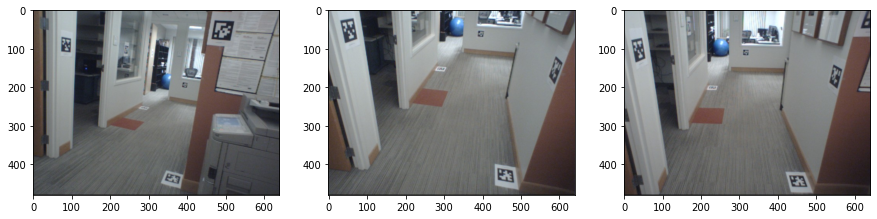

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img1[:, :, ::-1])
axes[1].imshow(img2[:, :, ::-1])
axes[2].imshow(img3[:, :, ::-1])

In [ ]:
# Camera Intrinsic Parameters

In [ ]:
fx = 520.544057821402
fy = 520.1849733954289
cx = 291.4731915436965
cy = 239.5481569250349
k1 = -0.09121325191796478
k2 = 0.1657800009678882
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
distCoeffs = np.array([k1, k2, 0, 0])[:, None]

In [ ]:
# ORB descriptors + Matching

In [ ]:
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
kp3, des3 = orb.detectAndCompute(img3,None)

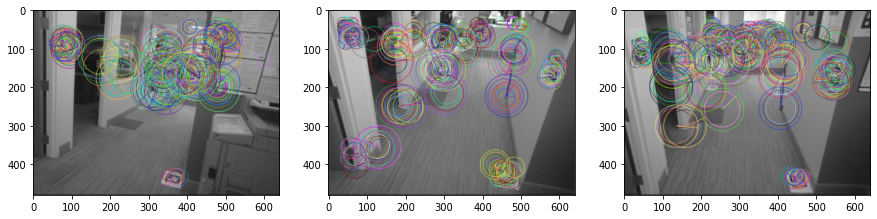

In [ ]:
img_kp1 = cv2.drawKeypoints(gray1, kp1, deepcopy(img1), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp2 = cv2.drawKeypoints(gray2, kp2, deepcopy(img2), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp3 = cv2.drawKeypoints(gray3, kp3, deepcopy(img3), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img_kp1[:, :, ::-1])
axes[1].imshow(img_kp2[:, :, ::-1])
axes[2].imshow(img_kp3[:, :, ::-1])

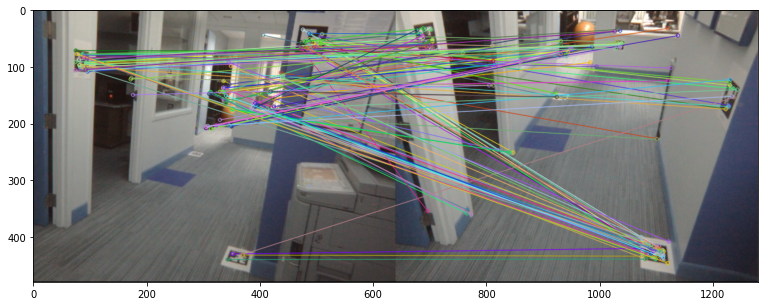

(<matplotlib.image.AxesImage at 0x7fec7164c090>, None)

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches12 = bf.match(des1,des2)

img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match),plt.show()

In [ ]:
# Pose 1 and Pose 2

In [ ]:
pts1_obs = []
pts2_obs = []

for m in matches12:
    pts1_obs.append(kp1[m.queryIdx].pt)
    pts2_obs.append(kp2[m.trainIdx].pt)

pts1_obs = np.array(pts1_obs)
pts2_obs = np.array(pts2_obs)
_, E, R, t, mask12 = cv2.recoverPose(pts1_obs, pts2_obs, K, distCoeffs, K, distCoeffs)
mask12 = mask12.ravel().astype(bool)
matches12_valid = [matches12[i] for i in range(len(mask12)) if mask12[i]]
print("%d pairs of matches, %d are valid." % (len(matches12), len(matches12_valid)))

136 pairs of matches, 11 are valid.


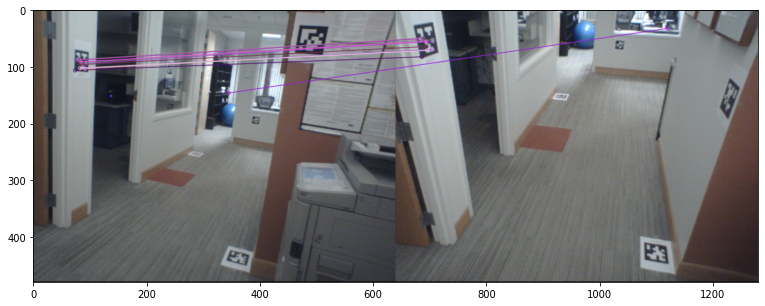

In [ ]:
img_match12_valid = cv2.drawMatches(img1, kp1, img2, kp2, matches12_valid, None, 
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match12_valid[:, :, ::-1])
plt.show()

In [ ]:
rvec1 = np.array([0., 0., 0.])
tvec1 = np.array([0., 0., 0.])
rvec2 = cv2.Rodrigues(R)[0].ravel()
tvec2 = t.ravel()
print("pose1:")
print(rvec1, tvec1)
print("pose2:")
print(rvec2, tvec2)

pose1:
[0. 0. 0.] [0. 0. 0.]
pose2:
[ 0.14789631  0.1652367  -0.21934318] [ 0.06902012  0.32718256 -0.94243716]


In [ ]:
# Triangulate Points

In [ ]:
projMat1 = K @ np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1)
projMat2 = K @ np.concatenate((R, t), axis=1)
pts1_obs = pts1_obs[mask12]
pts2_obs = pts2_obs[mask12]
print(pts2_obs.shape)
pts_obj = cv2.triangulatePoints(projMat1, projMat2, pts1_obs.T, pts2_obs.T)
pts_obj = pts_obj / pts_obj[-1]
pts_obj = pts_obj[:3].T
print(pts_obj[:10])

(11, 2)
[[ 0.31504827 -0.54966434  3.06637946]
 [-0.94754786 -0.58262058  2.26816574]
 [-0.84213326 -0.57546959  2.18736649]
 [-0.84197734 -0.616317    2.20732341]
 [-0.84829239 -0.628664    2.22330536]
 [-0.90251113 -0.643567    2.26256374]
 [-0.92208968 -0.65480493  2.24831657]
 [-0.91971468 -0.66444985  2.27300905]
 [-0.85305002 -0.58242622  2.20384385]
 [-0.89770643 -0.59366994  2.24005449]]


In [ ]:
# 2D To 3D Matching

In [ ]:
# construct the descriptor array for 3D object points
des_3d = []

for m in matches12_valid:
  des_3d.append(des1[m.queryIdx])
  des_3d.append(des2[m.trainIdx])

des_3d = np.array(des_3d)

matches3w = bf.match(des3, des_3d)

pts3_obs = []
ptsW = []
pts_idx_3d = []

for m in matches3w:
  pts3_obs.append(kp3[m.queryIdx].pt)
  ptsW.append(pts_obj[m.trainIdx // 2])
  pts_idx_3d.append(m.trainIdx // 2)

pts3_obs = np.array(pts3_obs)
ptsW = np.array(ptsW)

# solve for pose3
ret, rvec, tvec, inliers = cv2.solvePnPRansac(ptsW, pts3_obs, K, distCoeffs)
inliers = inliers.ravel()
rvec3 = rvec.ravel()
tvec3 = tvec.ravel()
pts3_obs = pts3_obs[inliers]
print("%d 2D to 3D matches, %d are valid." % (len(matches3w), len(inliers)))
print("pose3:")
print(rvec3, tvec3)

12 2D to 3D matches, 5 are valid.
pose3:
[ 0.50548754 -0.33366237 -0.2251161 ] [0.50776375 0.63204059 1.14445603]


In [ ]:
# Bundle Adjustment
# create inital parameter array

In [ ]:
params0 = np.concatenate([rvec1, rvec2, rvec3, tvec1, tvec2, tvec3, pts_obj.ravel()]) # 6 * 3 + 3 * 65 = 213
print("# of parameters: %d" % len(params0))

# of parameters: 51


In [ ]:
# create visibility matrix

In [ ]:
n_cams = 3
n_points = len(pts_obj)
visibility = []
for i in range(n_cams):
  if i < 2:
    visibility.append(np.ones(n_points, dtype=bool))
  else:
    vis_mask = np.zeros(len(pts_idx_3d), dtype=bool)
    vis_mask[inliers] = True
    visibility.append(vis_mask)
# visibility = np.array(visibility)
print("visibility:")
print(visibility)

visibility:
[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), array([ True, False, False,  True,  True,  True, False, False, False,
        True, False, False])]


In [ ]:
# create observations

In [ ]:
pts_obs = np.concatenate([pts1_obs, pts2_obs, pts3_obs]) 
print("# of observed 2d points: %d" % len(pts_obs))

# of observed 2d points: 27


In [ ]:
# object function

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


(-10.0, 10.0)

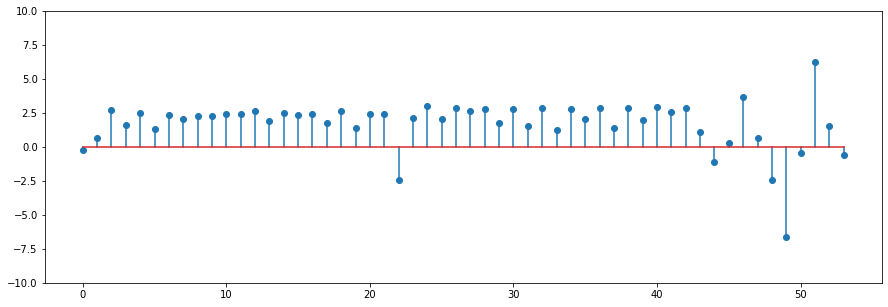

In [ ]:
def fun(params, K, distCoeffs, n_cams, visibility, x_obs):
    rvecs = params[:3*n_cams]
    tvecs = params[3*n_cams:6*n_cams]
    X = params[6*n_cams:] 
    x_hat = []
    for i in range(n_cams):
        rvec, tvec = rvecs[i*3:i*3+3], tvecs[i*3:i*3+3]
        mask = visibility[i]
        if i == 2:
          x = cv2.projectPoints(X.reshape(-1, 3)[pts_idx_3d], rvec, tvec, K, distCoeffs)[0][mask, 0, :] #N_ix2
        else:
          x = cv2.projectPoints(X.reshape(-1, 3), rvec, tvec, K, distCoeffs)[0][mask, 0, :] #N_ix2
        x_hat.append(x)
    x_hat = np.concatenate(x_hat) 
    return (x_hat - x_obs).ravel()

err = fun(params0, K, distCoeffs, 3, visibility, pts_obs)
plt.stem(err)
plt.ylim([-10, 10])

In [ ]:
# Optimize

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6824e+02                                    2.73e+04    
       1              4         2.4387e+01      1.44e+02       3.57e-01       1.39e+03    
       2              6         1.3253e+01      1.11e+01       2.22e-01       8.50e+02    
       3              7         1.2481e+01      7.72e-01       3.64e-01       2.99e+03    
       4              8         4.1543e+00      8.33e+00       8.40e-02       6.11e+01    
       5              9         2.9407e+00      1.21e+00       1.31e-01       8.53e+02    
       6             11         2.4320e+00      5.09e-01       7.00e-02       2.80e+02    
       7             13         2.3213e+00      1.11e-01       4.25e-02       9.55e+01    
       8             14         2.2999e+00      2.14e-02       1.12e-01       4.97e+02    
       9             15         2.1621e+00      1.38e-01       2.47e-02       3.33e+01    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


(-10.0, 10.0)

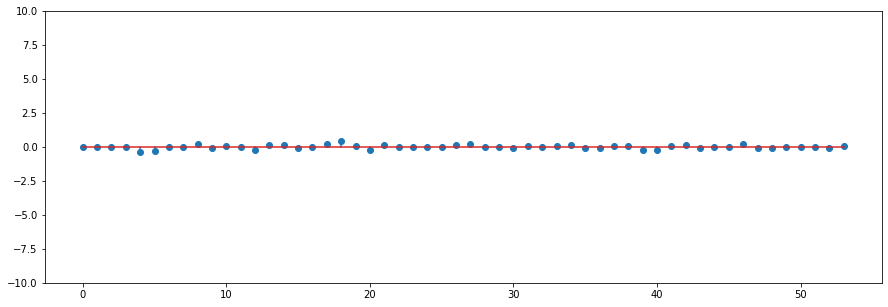

In [ ]:
res = least_squares(fun, params0, verbose=2, x_scale='jac', ftol=1e-8, method='trf', args=(K, distCoeffs, 3, visibility, pts_obs))
rvec1_o, rvec2_o, rvec3_o = res.x[:3], res.x[3:6], res.x[6:9]
tvec1_o, tvec2_o, tvec3_o = res.x[9:12], res.x[12:15], res.x[15:18]
print("pose1:")
print(rvec1_o, tvec1_o)
print("pose2:")
print(rvec2_o, tvec2_o)
print("pose3:")
print(rvec3_o, tvec3_o)
pts_obj_o = res.x[18:].reshape(-1, 3)
plt.stem(res.fun)
plt.ylim([-10, 10])

In [ ]:
# Match descriptors between img1 and img2
  matches12 = bf.match(des1, des2)

  img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  # plt.imshow(img_match),plt.show()
  pts1_obs = []
  pts2_obs = []

  for m in matches12:
    pts1_obs.append(kp1[m.queryIdx].pt)
    pts2_obs.append(kp2[m.trainIdx].pt)

  pts1_obs = np.array(pts1_obs)
  pts2_obs = np.array(pts2_obs)
  _, E, R, t, mask12 = cv2.recoverPose(pts1_obs, pts2_obs, K, distorC, K, distorC)
  mask12 = mask12.ravel().astype(bool)
  matches12_valid = [matches12[i] for i in range(len(mask12)) if mask12[i]]

  if (len(matches12) > 1): # if there are at least 100 matches add to 
    print(fname)
    print("-> %d pairs of matches, %d are valid." % (len(matches12), len(matches12_valid)))
    img_match12_valid = cv2.drawMatches(img1, kp1, img2, kp2, matches12_valid, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_match12_valid)
    plt.show()
    add = cv2.imread(fname)
    M_imgs.append(add)